<a href="https://colab.research.google.com/github/monya-9/deep-learning-practice/blob/main/06_bert_sentence_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HuggingFace BERT 불러서 문장 분류

In [ ]:
# 1. 라이브러리 설치 (colab 환경일 경우)
!pip install --upgrade transformers datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 70.8 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.55.0
    Uninstalling transformers-4.55.0:
      Successfully uninstalled transformers-4.55.0


In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset
import torch
import matplotlib.pyplot as plt

In [ ]:
# 2. 데이터셋 불러오기 (IMDb 리뷰)
dataset = load_dataset("imdb")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

- IMDb 리뷰 데이터셋 로드
- train/test로 나뉘어 있음
- dataset['train'], dataset['test']로 접근 가능

In [ ]:
# 3. 토크나이저 불러오기 (BERT-base-uncased)
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

- 문장을 BERT 입력 형식을로 변환
- 입력 토큰, 어텐션 마스크 등을 생성
- bert-base-uncased: 소문자 기반 BERT 모델

In [ ]:
# 4. 토크나이징 함수
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

- 문장을 토큰화하고 길이를 128 토큰으로 제한
- 배치 단위로 토큰화(bached=True)
- 모델 입력용 input_ids, attention_mask 생성

In [ ]:
# 5. 데이터셋 형식 설정
tokenized_datasets.set_format("torch", columns=["input_ids", "attention_mask", "label"])

train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(2000))  # 소규모 학습
test_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(500))

- HuggingFace datasets는 기본적으로 Python dict 또는 pandas 형식
- shuffle(seed=42) : 데이터 순서를 랜덤하게 섞음, seed 고정 → 재현성 보장
- select(range(...)) : 처음 N개 샘플만 선택

In [ ]:
# 6. 모델 불러오기 (이진 분류 num_labels=2)
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


- 사전 학습 BERT 불러오기
- num_labels=2: IMDb 긍정/부정 2개 클래스 분류

In [ ]:
# 7. 학습 설정
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    report_to="none"
)

- output_dir: 모델 체크포인트 저장
- evaluation_starategy="epoch": 매 epoch마다 평가
- learning_rate: 학습률
- batch_size, epoch, weight_decay 등 설정

In [ ]:
# 8. Trainer 정의
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
)

/tmp/ipython-input-3266237281.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


- Trainer가 학습 루프, 평가, 로깅을 자동 처리
- PyTorch 코드 수동 작성 필요 없음

Step,Training Loss
10,0.708400
20,0.666200
30,0.647400
40,0.615200
50,0.440300
60,0.511300
70,0.434200
80,0.568600
90,0.402900
100,0.420900


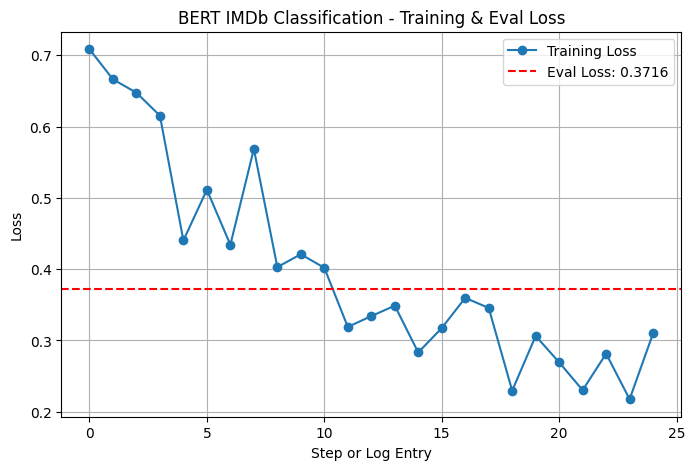

In [ ]:
# 9. 학습 및 평가
trainer.train()
eval_result = trainer.evaluate()

# Trainer 학습 후
train_losses = []
eval_losses = []

for log in trainer.state.log_history:
    if "loss" in log:
        train_losses.append(log["loss"])
    if "eval_loss" in log:
        eval_losses.append(log["eval_loss"])

# 시각화
plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Training Loss", marker='o')
if eval_losses:
    plt.axhline(y=eval_losses[-1], color='r', linestyle='--', label=f"Eval Loss: {eval_losses[-1]:.4f}")
plt.xlabel("Step or Log Entry")
plt.ylabel("Loss")
plt.title("BERT IMDb Classification - Training & Eval Loss")
plt.legend()
plt.grid(True)
plt.show()